In [1]:
import pandas as pd
import numpy as np
import re
import nltk, spacy
import scipy.sparse as sp
# Recarga automática de las bibliotecas
%load_ext autoreload 

## Un ejemplo de Clasificación de texto

Utilicemos nuestro tokenizador para resolver un problemas de clasificación de texto. Para ello utilizaremos el conjunto de tweets en Inglés para la competencia **HaHackathon: Detecting and Rating Humor and Offense** (https://competitions.codalab.org/competitions/27446). En terminos simples la competencia consiste en cuatro tareas:

- Identificar si un tweet es o no chiste (binario)
- Identificar que tan gracioso es el chiste (valor real entre 0 y 5)
- Identificar si un tweet es o no controvertido (binario)
- Identificar que tan ofensivo es (valor real entre 0 y 5)


In [2]:
# El conjunto de entrenamiento
train_df=pd.read_csv('data/humor/train_english.tgz', compression='gzip')
train_df.head()

,._train.csv,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1.0,TENNESSEE: We're the best state. Nobody even c...,1.0,2.42,1.0,0.2
1,2.0,A man inserted an advertisement in the classif...,1.0,2.50,1.0,1.1
2,3.0,How many men does it take to open a can of bee...,1.0,1.95,0.0,2.4
3,4.0,Told my mom I hit 1200 Twitter followers. She ...,1.0,2.11,1.0,0.0
4,5.0,Roses are dead. Love is fake. Weddings are bas...,1.0,2.78,0.0,0.1


In [3]:
train_df.text.values[3]

"Told my mom I hit 1200 Twitter followers. She pointed out how my brother owns a house and I'm wanted by several collection agencies. Oh ma!"

Cada campo se define como sigue:

- **text** Es el texto del tweet
- **is_humor** 0 si no es un chiste, 1 en caso contrario,
- **humor_rating** score de `graciosidad` promedio de votación de 0 a 5 estrellas. 	
- **humor_controversy** 1 si el controvertido, 0 en caso contrarion
- **offense_rating** score de `ofensividad` promedio de votación de 0 a 5 estrellas.

Por ahora solo nos enfocaremos en la tarea de detección de humor. Podemos cargar solo las columnas que no interesan.

In [4]:
train_df=pd.read_csv('data/humor/train_english.tgz', compression='gzip',usecols=['is_humor','text'])
test_df=pd.read_csv('data/humor/dev_english.csv',usecols=['is_humor','text']) 
train_df=train_df.dropna().astype({'is_humor': 'int32'})
test_df=test_df.dropna().astype({'is_humor': 'int32'})

In [5]:
train_df # conjusnto de entrenamiento

,text,is_humor
0,TENNESSEE: We're the best state. Nobody even c...,1
1,A man inserted an advertisement in the classif...,1
2,How many men does it take to open a can of bee...,1
3,Told my mom I hit 1200 Twitter followers. She ...,1
4,Roses are dead. Love is fake. Weddings are bas...,1
...,...,...
7995,Lack of awareness of the pervasiveness of raci...,0
7996,Why are aspirins white? Because they work sorry,1
7997,"Today, we Americans celebrate our independence...",1
7998,How to keep the flies off the bride at an Ital...,1


In [6]:
test_df # conjusnto de prueba

,text,is_humor
0,What's the difference between a Bernie Sanders...,1
1,"Vodka, whisky, tequila. I'm calling the shots.",1
2,French people don't masturbate They Jacque off,1
3,A lot of Suicide bombers are Muslims - I don't...,1
4,What happens when you fingerbang a gypsy on he...,1
...,...,...
995,boss: what are you doing inventor of the bagpi...,1
996,I told him his views were pretty extreme and i...,0
997,"""Mum, all the black kids call each other Nigga...",1
998,"In honor of Fathers Day, I'm gonna bring you ""...",0


<AxesSubplot:>

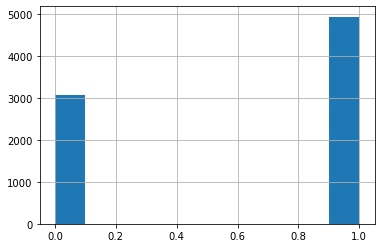

In [7]:
train_df.is_humor.hist()

<AxesSubplot:>

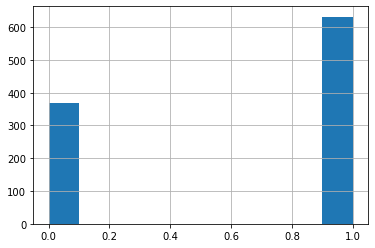

In [8]:
test_df.is_humor.hist()

La siguiente tabla muestra los resultados obtenidos en accuracy y F-Score por los 10 mejores equipos. Los datos son sobre el conjuntos de prueda en dev.csv.


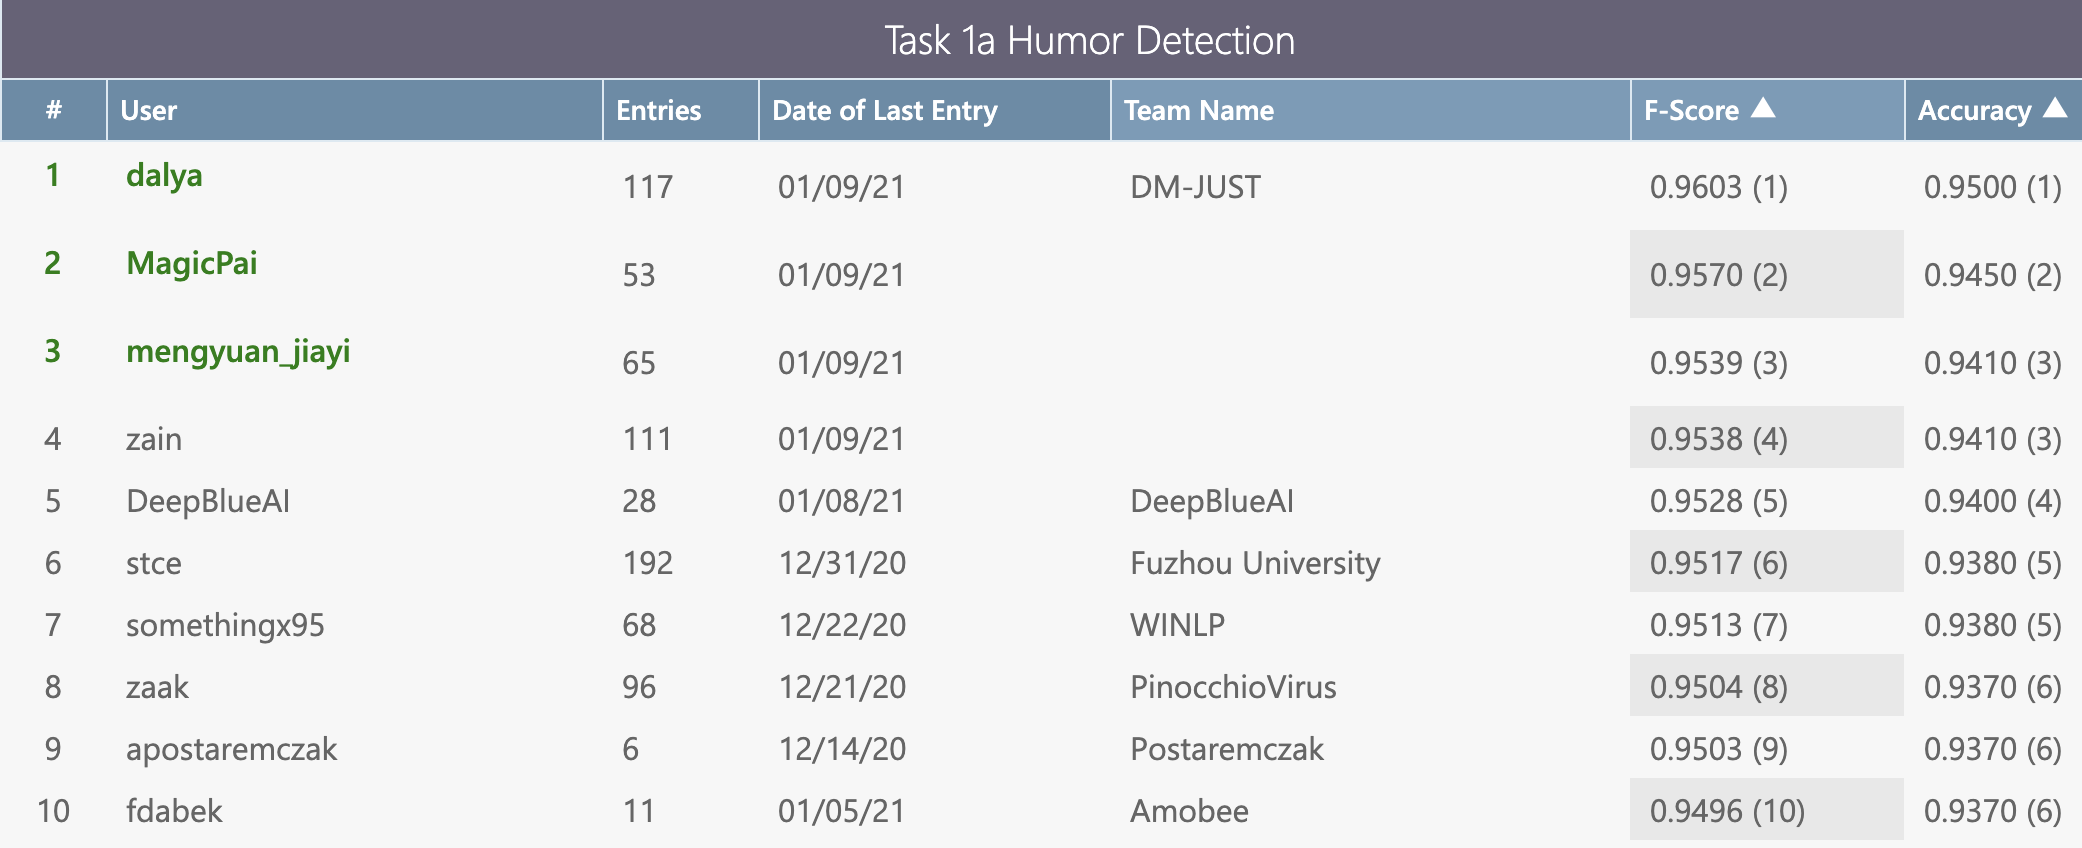

**Nota**: Aún cuando para nuestro ejercio ya conocemos las etiquetas del conjunto de prueba. Eso nunca pasa en sistemas reales, por lo que los datos de prueba no deben usarse en el entrenamiento del modelo.  

Recuerde que las funciones para accuracy y F-Score son parte de la librería `sklearn.metrics`.

In [9]:
from sklearn.metrics import f1_score as f1, accuracy_score as acc

In [10]:
# Si predijeramos siempre la clase correcta
y,yp=test_df.is_humor,test_df.is_humor
print("F-Score: {} Acurracy: {} ".format(f1(y,yp),acc(y,yp)))

F-Score: 1.0 Acurracy: 1.0 


In [11]:
# Si predijeramos siempre 1
y=test_df.is_humor
yp=[1 for i in range(len(test_df.is_humor))]
print("F-Score: {} Accuracy: {} ".format(f1(y,yp),acc(y,yp)))

F-Score: 0.7745098039215685 Accuracy: 0.632 


In [12]:
# Si predijeramos siempre 0
y=test_df.is_humor
yp=[0 for i in range(len(test_df.is_humor))]
print("F-Score: {} Accuracy: {} ".format(f1(y,yp),acc(y,yp)))

F-Score: 0.0 Accuracy: 0.368 


Ahora usaremos el tokenizador simple para describir el proceso completo. Primero debemos hacer la implementación de nuestro tokenizador.

In [13]:
from SimpleNLP import Tokenizer
# Entrenamos el modelo
tk=Tokenizer(derivador='stem')
tk.fit(train_df.text)

In [14]:
len(tk.vocabulario_index)

22328

In [15]:
# Transformamos el conjunto de entrenamiento:
train=tk.transform(train_df.text)

In [16]:
train

<8000x22328 sparse matrix of type '<class 'numpy.int64'>'
	with 150030 stored elements in Compressed Sparse Row format>

In [36]:
# utilizaremos un clasificador del vecino más cercano
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(train,train_df.is_humor)

KNeighborsClassifier()

In [37]:
# Transformamos el conjunto de prueba
test=tk.transform(test_df.text)

In [38]:
print(test.shape)
print(train.shape)

(1000, 22328)
(8000, 22328)


In [31]:
#Predecimos  y evaluamos, para problemas de texto con representaciones de bag of words
#por lo general es mejor usas modelos lineales como SVM, NearestCentroid, Naïve Bayes...
yp=clf.predict(test)
print("F-Score: {} Accuracy: {} ".format(f1(y,yp),acc(y,yp)))

F-Score: 0.8391608391608392 Accuracy: 0.793 


<div class="alert alert-success">
<b>Tarea</b>:<br />
    
Compare el desempeño de tres clasificadores (elija aquellos que soporten matrices dispersas) que utilice el modelo generado por su tokenizador y los resultados obtenidos en la competencia real. Pruebe los siguientes casos:
<ul>
    <li>Sin incluir ningun tipo de normalización</li>
    <li>Incluir todas las normalizaciones</li>
    <li>Incluir $n$-gramas de tamaño 2</li> 
    <li>Proponer un combinación</li>
</ul>
Reporte los resultados en un notebook, utilice tablas cuando sea posible.
</div>

### Breve revisión de matrices dispersas

Esta se encuentran definidas en la librería en el modulo scipy.sparse. Para nuestro proyecto solo utilizaremos **csr_matrix**. Los generaremos como matrices de $1 \times N$ donde $N$ es el tamaño del vocabulario.

Como ejemplo consider que un documento de un vocabulario de $N=10$ solo contiene los elementos 0,5 y 7.

La representación densa, quedaría como sigue:

In [21]:
v_denso=np.zeros(10).astype(int) 
v_denso[[0,5,7]]=1
v_denso

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

El tipo **csr_matrix** permite especificar una matriz dispersa de $M \times N$ mediante `csr_matrix((X, (R,C)), shape=(M,N))`, donde:
- **X** una lista con los valores $x_i \in X$ 
- **R** una lista de enteros donde cada $r_i \in R$ corresponde al indice del renglón de $x_i$.
- **C** una lista de enteros donde cada $c_i \in R$ corresponde al indice de la columna que ocupa $x_i$.


por ejemplo el vector del ejemplo anterior lo podemos especificar como sigue:

In [22]:
X=[1,1,1]
R=[0,0,0] # como solo tiene un renglón todes corresponden al 0
C=[0,5,7]
v_sparse=sp.csr_matrix((X,(R,C)),shape=(1,10))
print(v_sparse, v_sparse.shape)

  (0, 0)	1
  (0, 5)	1
  (0, 7)	1 (1, 10)


In [23]:
#podemos ver su versión densa
v_sparse.toarray()

array([[1, 0, 0, 0, 0, 1, 0, 1, 0, 0]])

In [24]:
# podemos apilar las matrices dispersas para construir como sige
v=v_sparse
M=sp.vstack([v,v,v,v,v])
print(f"Dimension: {M.shape}, Tipo {type(M)}")

Dimension: (5, 10), Tipo <class 'scipy.sparse.csr.csr_matrix'>


In [25]:
M.toarray()

array([[1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 0]])

Para mayor información acerca de la implementación y uso de `csr_matrix` pued consultar el siguiente enlace:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

In [26]:
['lo', 'amigo', 'de', 'fox']

['lo', 'amigo', 'de', 'fox']

In [27]:
def ngram(texto, n=3):
    ngramas=[]
    for i in range(0,len(texto)-(n-1)):
        ngramas.append(' '.join(texto[i:i+n]))
    return ngramas

In [28]:
['los', 'amigos', 'de', 'fox']+ngram(['los', 'amigos', 'de', 'fox'])

['los', 'amigos', 'de', 'fox', 'los amigos de', 'amigos de fox']

In [29]:
!pip uninstall autoreload

In [35]:
print(np.isin.__doc__)


    Calculates `element in test_elements`, broadcasting over `element` only.
    Returns a boolean array of the same shape as `element` that is True
    where an element of `element` is in `test_elements` and False otherwise.

    Parameters
    ----------
    element : array_like
        Input array.
    test_elements : array_like
        The values against which to test each value of `element`.
        This argument is flattened if it is an array or array_like.
        See notes for behavior with non-array-like parameters.
    assume_unique : bool, optional
        If True, the input arrays are both assumed to be unique, which
        can speed up the calculation.  Default is False.
    invert : bool, optional
        If True, the values in the returned array are inverted, as if
        calculating `element not in test_elements`. Default is False.
        ``np.isin(a, b, invert=True)`` is equivalent to (but faster
        than) ``np.invert(np.isin(a, b))``.

    Returns
    -------
